In [24]:
### standard imports
import matplotlib.pyplot as plt
import pyvo as vo
import pandas as pd
import numpy as np

### astropy
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table, join

import sys
sys.path.append('../')
import corecomposition as cc

# Define the Gaia DR3 source_id you're interested in
bronze = Table.read('../data/processed/bronze.csv')

In [25]:
photo = cc.photometry.fetch_photometry(bronze['wd_source_id']) # fetch PANSTARRS and DES photometry for the source_ids in the sample
bronze = join(bronze, photo, keys_left='wd_source_id', keys_right='source_id') # join the two on the wd source_id

In [ ]:
# information needed for MCMC fitting each target
source_ids = bronze['wd_source_id'] # array of source_ids
coords = [SkyCoord(frame="galactic", l=bronze['wd_l'][i]*u.deg, b=bronze['wd_b'][i]*u.deg, distance = bronze['r_med_geo'][i] * u.pc) for i in range(len(bronze))] # contains the locations of each target
astrometric_params = bronze['wd_astrometric_params_solved'] # used for correcting g-band in Tyler's code
photo = np.array([bronze['wd_phot_g_mean_mag'], bronze['wd_phot_bp_mean_mag'], bronze['wd_phot_rp_mean_mag']]).T # the basic Gaia photometry
e_photo = np.array([bronze['wd_e_gmag'], bronze['wd_e_bpmag'], bronze['wd_e_rpmag']]).T # Gaia photometry error
initial_params = np.array([[10000]*len(bronze), bronze['cmd_radius']]).T # initial guesses

In [ ]:
# dustmap for dereddening
from dustmaps.edenhofer2023 import Edenhofer2023Query
bsq = Edenhofer2023Query()

Optimizing map for querying (this might take a couple of seconds)...


In [ ]:
obj = cc.photometry.Photometry(source_ids, coords, astrometric_params, photo, e_photo, initial_params, bsq)

100%|██████████| 30/30 [00:00<00:00, 41.27it/s]


In [ ]:
# 1307515077152381568
obj.bands[0]

array(['Gaia_G', 'Gaia_BP', 'Gaia_RP', 'PS1_g', 'PS1_r', 'PS1_i', 'PS1_z'],
      dtype='<U7')

In [ ]:
i = 14
source_ids = obj.source_ids[i]
distance = obj.geometry[i].distance.value
bands = obj.bands[i]
photomet = obj.photometry[i]
e_photomet = obj.e_photometry[i]
initial_guess = obj.initial_guess[i]

base_wavl, model_spec, model_spec_low_logg, table = cc.interpolator.utils.build_warwick_da()
build_spec = lambda best_est, distance : 4*np.pi*model_spec((best_est[0], 9)) * ((best_est[1] * 6.957e8) / (distance * 3.086775e16))**2

In [ ]:
photomet

array([19.46771948, 19.61322792, 19.00998532, 19.53757501, 18.81982156,
       18.60212859, 18.61894437, 18.03648932])

In [ ]:
from corecomposition import interpolator
import corner

import pyphot
lib = pyphot.get_library()

def fit_coarse(use_bands, bands, photo, e_photo, source_ids, distance, astrometric_params, initial_params):
    idx = [item in use_bands for item in bands]
    gaia_model = interpolator.LaPlataUltramassive(use_bands, core = 'CO', layer = 'Hrich')
    # run the MCMC fit using one of the interpolators
    gaia_engine = interpolator.CoarseEngine(gaia_model)
    initial_guess = [initial_params[0], 9, initial_params[1]]

    print(photo[idx])
    
    return gaia_engine, gaia_engine(photo[idx], e_photo[idx], distance, p0=initial_guess)

def fit_mcmc(use_bands, bands, photo, e_photo, source_ids, distance, astrometric_params, initial_params):
    idx = [item in use_bands for item in bands]
    gaia_model = interpolator.LaPlataUltramassive(use_bands, core = 'CO', layer = 'Hrich')
    # run the MCMC fit using one of the interpolators
    gaia_engine = interpolator.MCMCEngine(gaia_model)
    return gaia_engine, gaia_engine.run_mcmc(photo[idx], e_photo[idx], distance, initial_guess)

def plot_corner(gaia_flat_chain):
    labels = [r'$T_{eff}$ $[K]$', r'Radius $[R_\odot]$']
    best_est = np.zeros((len(labels)))
    unc = []

    for i in range(len(labels)):
        mcmc = np.percentile(gaia_flat_chain[:, i],[16,50,84])
        best_est[i] = mcmc[1]
        unc.append(np.diff(mcmc))
    unc = np.array(unc)

    emcee_plot = corner.corner(gaia_flat_chain, labels=labels, truths = best_est, quantiles = [0.16, 0.5, 0.84], show_titles = True, 
                            title_fmt = '.3f', title_kwargs={"fontsize": 12})

    plt.show()
    
    return best_est

def show_fit(engine, photo, e_photo, teff, radius, distance, cmd_radius):
    try:
        model_flux = engine.get_model_flux([teff, radius])
    except:
        model_flux = engine.get_model_flux({'teff' : teff, 'radius' : radius})

    flux, e_flux = engine.mag_to_flux(photo, e_photo)
    wave = [lib[band].lpivot.to('angstrom').value for band in engine.bands]

    plt.errorbar(wave, flux, yerr = e_flux, linestyle = 'none', marker = 'None', color = 'k',
                        capsize = 5, label = 'Observed SED', zorder=100)
    plt.plot(wave, model_flux, 'bo', markersize = 10, label = 'Model SED')

    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    plt.text(0.8 * (xmax - xmin) + xmin, 0.8 * (ymax - ymin) + ymin, f'R = {radius:2.4f} $R_\odot$')
    plt.text(0.8 * (xmax - xmin) + xmin, 0.75 * (ymax - ymin) + ymin, f'Interp R = {cmd_radius} $R_\odot$')

    plt.xlabel(r'Wavelength [AA]')
    plt.ylabel(r'Flux [flam]')
    plt.legend()
    plt.xlim(4000, 11000)

#gaia_engine_coarse, params_coarse = fit_coarse(['Gaia_BP', 'Gaia_RP'], bands, photomet, e_photomet, source_ids, distance, astrometric_params, initial_guess)
#radius, e_radius, teff, e_teff, logg, e_logg, result = params

<>:58: SyntaxWarning: invalid escape sequence '\o'
<>:59: SyntaxWarning: invalid escape sequence '\o'
<>:58: SyntaxWarning: invalid escape sequence '\o'
<>:59: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_59757/1432348955.py:58: SyntaxWarning: invalid escape sequence '\o'
  plt.text(0.8 * (xmax - xmin) + xmin, 0.8 * (ymax - ymin) + ymin, f'R = {radius:2.4f} $R_\odot$')
/tmp/ipykernel_59757/1432348955.py:59: SyntaxWarning: invalid escape sequence '\o'
  plt.text(0.8 * (xmax - xmin) + xmin, 0.75 * (ymax - ymin) + ymin, f'Interp R = {cmd_radius} $R_\odot$')


[4.07250052e-17 5.83155343e-17 3.09515581e-17]


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [266.20381702 257.38404066]


Auto-Correlation Time = 266.20381701542937, additional steps = 11342


100%|██████████| 11342/11342 [03:19<00:00, 56.93it/s]


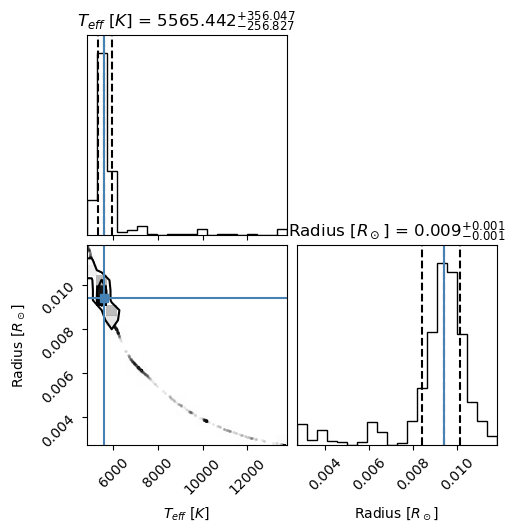

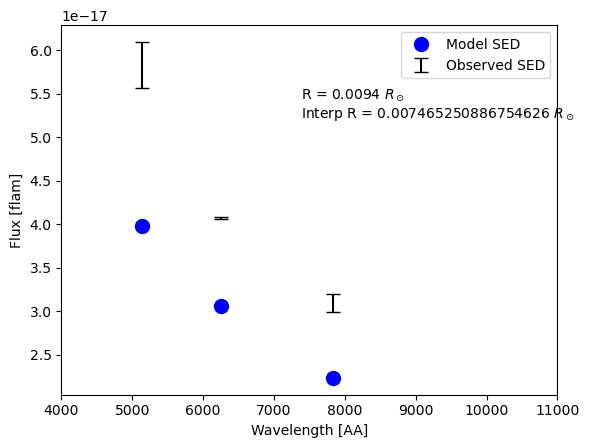

In [ ]:
use_bands = ['Gaia_G', 'Gaia_BP', 'Gaia_RP']
gaia_engine_mcmc, params_mcmc = fit_mcmc(use_bands, bands, photomet, e_photomet, source_ids, distance, astrometric_params, initial_guess)
best_est = plot_corner(params_mcmc)

cmd_radius = bronze[bronze['wd_source_id'] == source_ids]['cmd_radius'].data[0]
show_fit(gaia_engine_mcmc, photomet[0:3], e_photomet[0:3], best_est[0], best_est[1], distance, cmd_radius)